# Wasserstein GAN Study

The Wasserstein GAN (WGAN paper \[1\] proposed a new way of training the Generative Adversarial Nets (GANs) \[2\], which improves the stability and allows the discriminator can be trained to convergence. In particular, the authors proved that the Earth-Mover (EM) distance behaves better than the Jensen-Shannon (JS) divergence in terms of sensibility and smooth gradients. 

To demonstrate this property, the author provided some simple examples besides the rigorous math proofs. In this notebook, I'll replicate some of the results in the WGAN paper. First, we focus on replicating Figure 2:

![](fig2.png)

In this proof of concept experiment, the authors trained a GAN discriminator and a WGAN critic to differentiate two Gaussian distributions. The result shows that the GAN discriminator saturates while the WGAN critic has much nicer gradients. 

PyTorch is used in here for training.

In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Original GAN

About Figure 2, Ref. \[1\] says: 

> In Figure 2 we show a proof of concept of this, where we train a GAN discriminator and a WGAN critic till optimality. 

No more details are provided, we don't know what models and parameters are used, so we start from trying the most simple and basic model: 

In [2]:
disc = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid())

The discriminator's output is the probability of being real, so we use the $\mathrm{sigmoid}$ function as the last layer. 

In this experiment, the generator's distribution is fixed and we only train the discriminator. According to Ref. \[2\], we train the discriminator by maximizing the Jensen–Shannon divergence, which is equivalent to minimizing:
$$
-\mathbb{E}_{x\sim\mathbb{P}_r}[\log(D(x))] - \mathbb{E}_{x\sim\mathbb{P}_\theta}[\log(1 - D(x))]
$$

Now we train the discriminator: 

In [16]:
lr = 5e-1
bs = 64
N = 1000
for i in range(N):
    real = torch.randn([bs,1]) - 5
    fake = torch.randn([bs,1]) + 5    
    loss = - torch.log(disc(real)).mean() - torch.log(1 - disc(fake)).mean() 
    if i*10 % N == 0: print(loss.item())
    disc.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in disc.parameters():
            param -= lr * param.grad

0.0001980237866519019
0.0002780080249067396
6.355854566209018e-05
4.80399867228698e-05
7.15897767804563e-05
5.986582254990935e-05
5.329014311428182e-05
2.406522980891168e-05
2.7522968593984842e-05
3.9518330595456064e-05


Plot the output probabilities from the trained discriminator: 

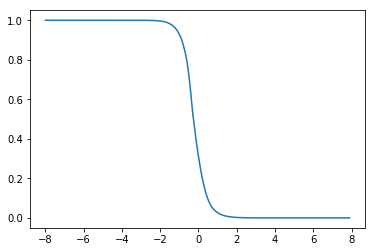

In [17]:
curv_x = np.arange(-8., 8., 0.1, dtype=np.float32)
with torch.no_grad():
    disc_y = disc(torch.from_numpy(curv_x).view(-1,1)).numpy()
plt.plot(curv_x, disc_y)

## WGAN

For WGAN, the output of the critic is not necessarily the probability, actually, it can be anything. Same as above, we also use a very simple model for the WGAN critic (just changed the last layer from $\mathrm{sigmoid}$ to $\tanh$):

In [12]:
crit = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Tanh())

For WGAN, instead of maximizing the Jensen–Shannon divergence, we maximize the Earth-Mover (EM) distance \[1\], which is equivalent to minimizing:
$$
\mathbb{E}_{x\sim\mathbb{P}_r}[f(x)] - \mathbb{E}_{x\sim\mathbb{P}_\theta}[f(x)]
$$

Train the critic to convergence:  

In [13]:
lr = 1e-1
bs = 64
N = 1500
for i in range(N):
    real = torch.randn([bs,1]) - 5
    fake = torch.randn([bs,1]) + 5    
    loss = crit(real).mean() - crit(fake).mean()
    if i*10 % N == 0: print(loss.item())
    crit.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in crit.parameters():
            param -= lr * param.grad
            param.data.clamp_(-0.1, 0.1)

-0.4577646553516388
-0.5747298002243042
-0.5712668895721436
-0.5769107341766357
-0.5647101402282715
-0.5770244598388672
-0.5889617800712585
-0.5850059986114502
-0.5951364040374756
-0.5723708868026733


Note after updating the weights, we clipped them to \[-0.1, 0.1\]. This is to make sure that the critic is _K_-Lipschitz \[1\].

Now we plot the outputs from the trained critic:

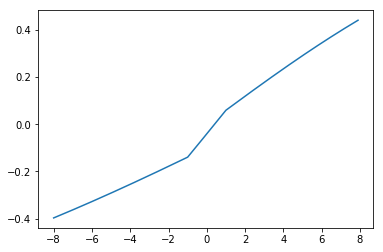

In [14]:
with torch.no_grad():
    crit_y = crit(torch.from_numpy(curv_x).view(-1,1)).numpy()
plt.plot(curv_x, crit_y)

## Put it together

We have trained the GAN discriminator and the WGAN critic, now we put all results into a single plot:

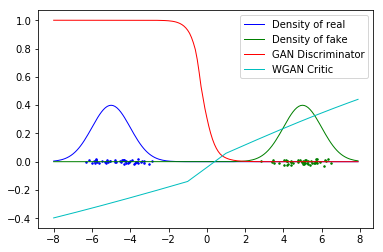

In [18]:
real_x = np.random.randn(50) - 5
real_y = np.random.randn(50)/100

fake_x = np.random.randn(50) + 5
fake_y = np.random.randn(50)/100

real_curv_y = np.exp(-np.power(curv_x + 5, 2)/2)/np.sqrt(2*np.pi)
fake_curv_y = np.exp(-np.power(curv_x - 5, 2)/2)/np.sqrt(2*np.pi)

plt.plot(real_x, real_y, '.b', markersize=3)
plt.plot(curv_x, real_curv_y, '-b', linewidth=1, label='Density of real')

plt.plot(fake_x, fake_y, '.g', markersize=3)
plt.plot(curv_x, fake_curv_y, '-g', linewidth=1, label='Density of fake')

plt.plot(curv_x, disc_y, '-r', linewidth=1, label='GAN Discriminator')
plt.plot(curv_x, crit_y, '-c', linewidth=1, label='WGAN Critic')
plt.legend()

It's almost identical to Figure 2 of Ref. \[1\]. We have replicated it with the most basic models. 

## References:
 
\[1\] Martin Arjovsky, Soumith Chintala, and Leon Bottou (2017). Wasserstein GAN ( https://arXiv:1701.07875 ).

\[2\] Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio (2014). Generative adversarial nets. In _Advances in Neural Information Processing Systems 27_, pages 2672–2680. Curran Associates, Inc.